In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pulp import *
from scipy.optimize import minimize

from dateutil.relativedelta import relativedelta

from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

pd.set_option('display.max_columns',500)

In [2]:
# In this notebook, I am going to take commodity pricing & quantity sales from available beef prices & 
# construct a price elasticity of demand curve in order to predict the effect of a specfic change in price 
# to the change in quantity sold

In [3]:
# Data can be viewed in the below link
beef_price = 'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/beef.csv'
beef_df = pd.read_csv(beef_price, index_col=0)
beef_df.reset_index(inplace=True)
beef_df

,Year,Quarter,Quantity,Price
0,1977,1,22.9976,142.1667
1,1977,2,22.6131,143.9333
2,1977,3,23.4054,146.5000
3,1977,4,22.7401,150.8000
4,1978,1,22.0441,160.0000
...,...,...,...,...
86,1998,3,17.5085,277.3667
87,1998,4,16.6475,279.5333
88,1999,1,16.6785,278.0000
89,1999,2,17.7635,284.7667


In [4]:
# just cleaning the dataframe & renaming
lst = beef_df.columns
cols1 = []
for x in lst:
    cols1.append(x.lower().strip().replace(' ','_'))
beef_df.columns=cols1
beef_df['yq'] = beef_df['year'].astype(str) + 'Q' + beef_df['quarter'].astype(str)
beef_df['yq'] = pd.to_datetime(beef_df['yq'])
df = beef_df[['yq','quantity', 'price', ]].copy()
df

/var/folders/0g/4l0cmb9j43jgr0cxr8nx6sdm0000gn/T/ipykernel_76838/1417565771.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  beef_df['yq'] = pd.to_datetime(beef_df['yq'])


,yq,quantity,price
0,1977-01-01,22.9976,142.1667
1,1977-04-01,22.6131,143.9333
2,1977-07-01,23.4054,146.5000
3,1977-10-01,22.7401,150.8000
4,1978-01-01,22.0441,160.0000
...,...,...,...
86,1998-07-01,17.5085,277.3667
87,1998-10-01,16.6475,279.5333
88,1999-01-01,16.6785,278.0000
89,1999-04-01,17.7635,284.7667


Text(0, 0.5, 'Price')

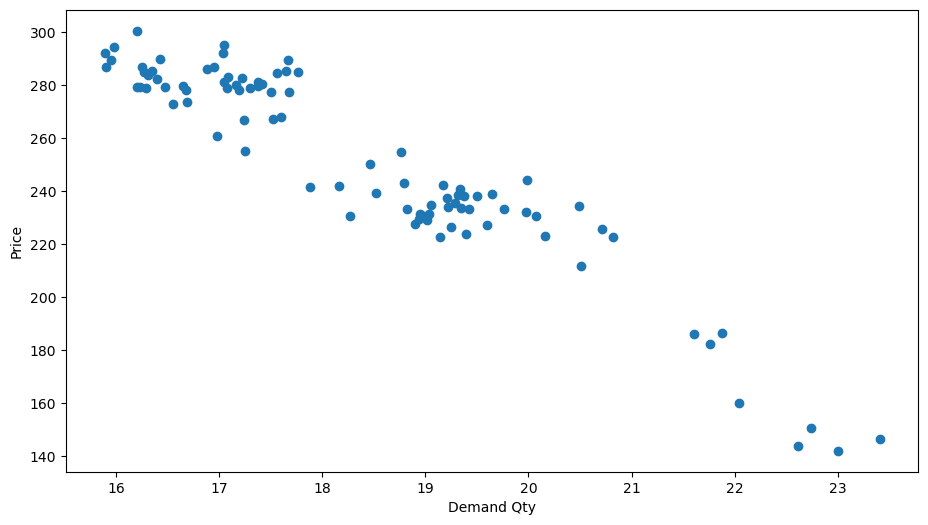

In [5]:
# viewing the scatter plot of the data, the time factor isn't really what we're concerned 
# about for this, so I am ignoring it for the purpose of this notebook and analysis

plt.figure(figsize=(11,6))
plt.scatter(x=df['quantity'], y=df['price'])
plt.xlabel(xlabel='Demand Qty')
plt.ylabel(ylabel='Price')

In [6]:
# splitting dependent and independent variables

X = df[['price']]
y = df[['quantity']]

In [7]:
# splitting into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# creating the linear regression model

lin_reg = LinearRegression()


# fitting the linear regression model for quantity sold (y or dependent variable) over price (X or the independent variable)

lin_reg.fit(X_train,y_train) 

LinearRegression()

In [9]:
# creating the predictions from the fitted model for training & test data sets

train_predictions = lin_reg.predict(X_train)
test_predictions = lin_reg.predict(X_test)

In [10]:
# now going to evaluate the model & interpret the results

print(f' Train RMSE {round(mean_squared_error(y_train,train_predictions,squared=False),3)}')
print(f' Train R^2 {round(r2_score(y_train,train_predictions),3)}')
print()
print(f' Train RMSE {round(mean_squared_error(y_test,test_predictions,squared=False),3)}')
print(f' Test R^2 {round(r2_score(y_test,test_predictions),3)}')
print()
print(f'Price coefficient {np.round(lin_reg.coef_[0],3)}')

 Train RMSE 0.548
 Train R^2 0.909

 Train RMSE 0.611
 Test R^2 0.882

Price coefficient [-0.047]


##### Train RMSE 0.548
##### Train R^2 0.909

##### Train RMSE 0.611
##### Test R^2 0.882

##### Price coefficient (-0.047)

Text(0, 0.5, 'Price')

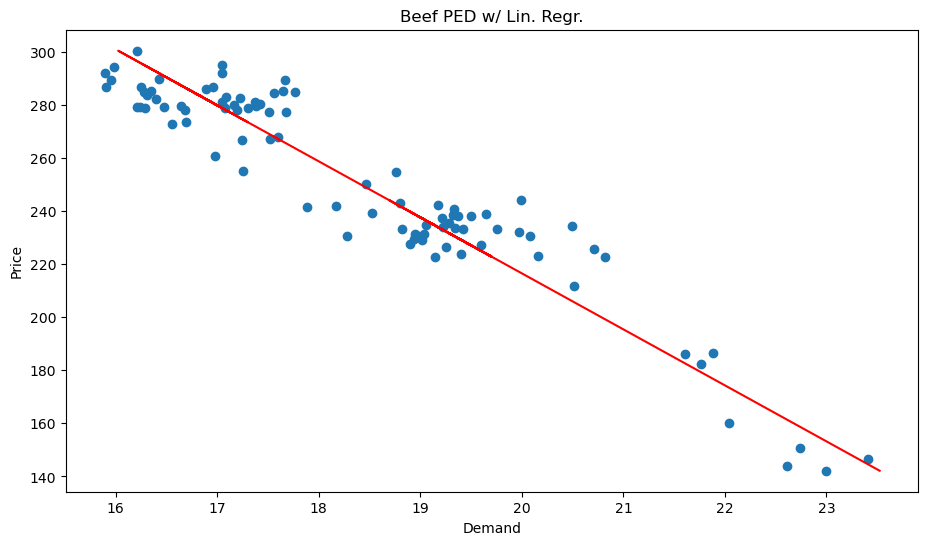

In [11]:
# scatter plot with the linear regression line included
fig, ax=plt.subplots(figsize=(11,6))
plt.scatter(y, X)
plt.plot(lin_reg.predict(X),X,color='r')
ax.set_title("Beef PED w/ Lin. Regr.")
ax.set_xlabel('Demand')
ax.set_ylabel('Price')

In [12]:
# Now that I have the linear regression line for the demand curve, I can input some price points and see
# the quantity sales predicted from the model

In [13]:
# Now can input two price points along our Price elasticity of demand line, put them into array format, and predict the quantity of beef sold

price1 = np.array(200)
price2 = np.array(220) 

# predictions of estimated demand at the price points. Re-shape the array and return first value

demand_est1 = lin_reg.predict(price1.reshape(1, -1))[0]
demand_est2 = lin_reg.predict(price2.reshape(1, -1))[0]

# plug in price points and demand estimates into our Price Elasticity of Demand formula
PED = ((demand_est2 - demand_est1)/(demand_est1))/((price2 - price1)/(price1)) 

#Print the price elasticity of demand estimation of going from 
print(f'PED {np.round(PED,2)}')

PED [-0.46]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Explanation:

#### Using the data available & prediction model I made, the estimated price elsaticity of demand of beef 
#### going from \\$220 to $200 (a 10% change in price in this case) would result in a 4.6% increase in the 
#### quantity of beef sold. Using this information, a business could make decisions about the expected tradeoffs
#### of a price change & if it would be more beneficial to lower the price (could also test to see the effects of a price increase, etc.)